# Naive Bayes Classifier

---
**Contents:**

1. Imports
2. Naive Bayes Application (Complete Use case)
---

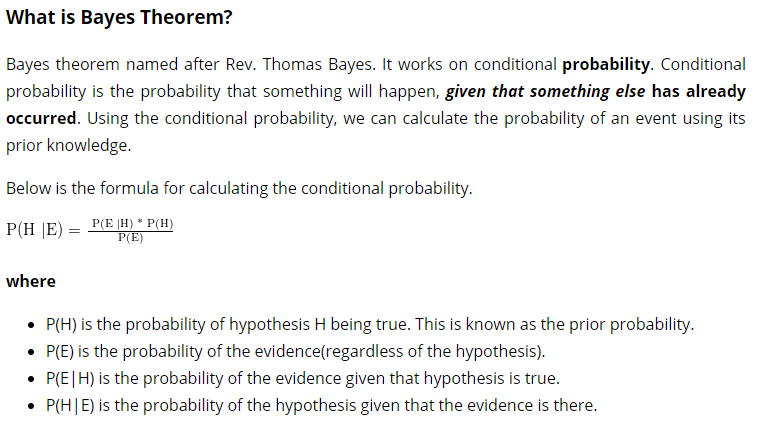

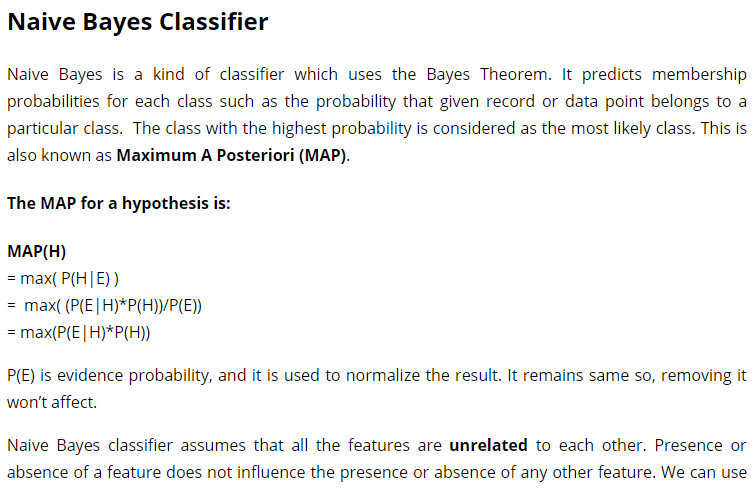

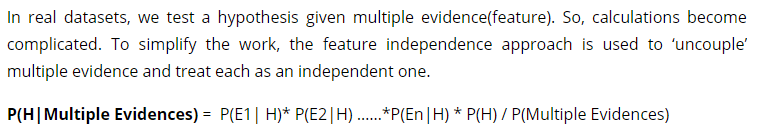

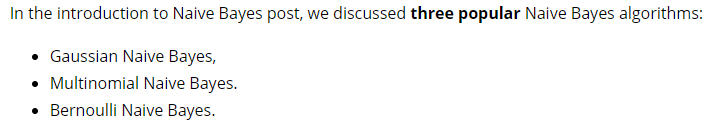

# 1. Imports

In [190]:
import pandas as pd
import numpy as np
import random

import category_encoders as CE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
                            precision_score, recall_score, f1_score, silhouette_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from gensim.models import word2vec

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, ticker as ticker
import seaborn as sns
import warnings
pd.set_option("display.max_columns", 80)
sns.set_style("whitegrid")
sns.set_palette('inferno')
warnings.filterwarnings('ignore')
%matplotlib inline

In [191]:
def plot_metrics(Y_test, Y_pred, labels):
    """
        Function to output complete accuracy metrics for binary and multi-class classifiers!
        labels: list - list of unique labels str or numeric
    
    """
    print("--------------\n:: METRICS ::\n--------------\n")
    cm = confusion_matrix(Y_test, Y_pred, labels=labels)
    model_type = 'binary' if len(set(np.array(labels))) <=2 else "multi"
    if model_type == 'binary':
        """
                Binary Classification
        """
        TP = cm[1,1]
        FP = cm[0,1]
        FN = cm[1,0]
        TN = cm[0,0]
    else:
        """
                Multi-class Classification
        """
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # PRECISION: Positive predictive value
        PPV = TP/(TP+FP)
        # RECALL: Sensitivity, hit rate, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        # Error Rate
        ER = (FP+FN)/(TP+FP+FN+TN)
        F1 = 2/(PPV**-1 + TPR**-1)
    
    # Confusion matrix PLOT
    fig, ax = plt.subplots(figsize=(4,2))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.show()
    # DISPLAY
    if model_type == 'binary':
        print("\nTP:{}\tFP:{}\tFN:{}\tTN:{}"\
              .format(round(TP,2), round(FP,2), round(FN,2), round(TN,2)))
    else:
        for i in range(len(labels)):
            print("\n****** Label `{}` *******\nTP:{}\tFP:{}\tFN:{}\tTN:{}\t >> Precision:{}\tRecall:{}\tF1:{}"\
                  .format(labels[i], round(TP[i],2), round(FP[i],2), round(FN[i],2), round(TN[i],2), \
                          round(PPV[i],2), round(TPR[i],2), round(F1[i],2)))
    print("\nOVERALL:")
    print("Accuracy \t==== \t{} %\nPrecision \t==== \t{} %\nRecall Score\t==== \t{} %\nF1 SCORE \t==== \t{} %"\
          .format(round(accuracy_score(Y_test, Y_pred)*100,3),
                  round(precision_score(Y_test, Y_pred, average='weighted')*100,3),
                  round(recall_score(Y_test, Y_pred, average='weighted')*100,3),
                  round(f1_score(Y_test, Y_pred, average='weighted')*100,3) ))
    return

----

# 2. Naive Bayes Application for Tweets Classification

### 1. Load dataset

In [192]:
# Load text dataset

data = pd.read_csv('../Data/processed_cuboulder_TwitterData.csv')
df = data[['tweet', 'Processed_tweet', 'label']]
df.insert(0, 'tweet_id', ["tweet_%d"%i for i in range(len(df))])
df

,tweet_id,tweet,Processed_tweet,label
0,tweet_0,"All campus dining locations are closed today, ...",campus dining location close today jan 1 happy...,cu_others
1,tweet_1,"What are your campus dining options today, Jan...",what your campus dining option today jan 2 alf...,cu_others
2,tweet_2,#FPGA Design for #Embedded #Systems\n\n#SoC #V...,fpga design embed system soc verilog vlsi asic...,cu_online
3,tweet_3,"What are your campus dining options today, Jan...",what your campus dining option today jan 3 alf...,cu_others
4,tweet_4,As an anthro PhD student I’m frequently asked ...,anthro phd student m frequently ask why study ...,cu_research
...,...,...,...,...
3389,tweet_3389,@CuLinguistics is proud of the 17 faculty &amp...,proud 17 faculty student give course panel tal...,cu_research
3390,tweet_3390,@breelynwilkyMD @CUCancerCenter @CUCancerInst ...,oncology immunology immunotherapy genetherapy ...,cu_research
3391,tweet_3391,@breelynwilkyMD @CUCancerCenter @CUCancerInst ...,sarcoma treatment treatment oncology immunolog...,cu_research
3392,tweet_3392,It has been one year since the Marshall Fire i...,one year since marshall fire boulder county co...,cu_research


- Our dataset was already preprocessed in earlier steps.

### 2. Setup

In [193]:
X = df[['tweet_id', 'Processed_tweet']]
Y = df['label']

In [194]:
X

,tweet_id,Processed_tweet
0,tweet_0,campus dining location close today jan 1 happy...
1,tweet_1,what your campus dining option today jan 2 alf...
2,tweet_2,fpga design embed system soc verilog vlsi asic...
3,tweet_3,what your campus dining option today jan 3 alf...
4,tweet_4,anthro phd student m frequently ask why study ...
...,...,...
3389,tweet_3389,proud 17 faculty student give course panel tal...
3390,tweet_3390,oncology immunology immunotherapy genetherapy ...
3391,tweet_3391,sarcoma treatment treatment oncology immunolog...
3392,tweet_3392,one year since marshall fire boulder county co...


In [195]:
Y

0         cu_others
1         cu_others
2         cu_online
3         cu_others
4       cu_research
           ...     
3389    cu_research
3390    cu_research
3391    cu_research
3392    cu_research
3393    cu_research
Name: label, Length: 3394, dtype: object

### 3. Split

In [196]:
# train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 7)
print(len(X_train), len(X_test))

2375 1019


In [197]:
# need to drop IDs, and keep only text!

X_train_uids = X_train['tweet_id']
X_train = X_train.Processed_tweet

X_test_uids = X_test['tweet_id']
X_test = X_test.Processed_tweet

In [226]:
X_train

524     much love seminar student who game move person...
864     not need sucker many student pay full tuition ...
2173     mean still try deflect their rapey football team
2898                                anyone know available
1691    dr chris desouza head colorado university arm ...
                              ...                        
1603    ve come long way last 5 year our work genderpa...
2550    bolster your career datascience learn fundamen...
537     next our lineup globalhealth speaker alum seco...
1220    see boulder third annual research innovation w...
175     american politics research lab share great inf...
Name: Processed_tweet, Length: 2375, dtype: object

In [227]:
Y_train

524       cu_online
864       cu_online
2173      cu_others
2898      cu_online
1691    cu_research
           ...     
1603    cu_research
2550      cu_online
537     cu_research
1220    cu_research
175     cu_research
Name: label, Length: 2375, dtype: object

In [228]:
X_test

1075    atlas prof ellen yi luen direct research acme ...
181     birth weight fall significantly recent decade ...
445     let covid19 keep see student art global pandem...
1657    research lead by professor publish show how ho...
2321    mechanical engineering ph d student oakland un...
                              ...                        
2686    15 17 dream study united state join educationu...
838     via agricultural application sulfur produce 10...
1898    artdaily recommend air pollution exposure preg...
2331    new research lead by see boulder researcher fi...
262                     change class rest semester chance
Name: Processed_tweet, Length: 1019, dtype: object

In [229]:
Y_test

1075    cu_research
181     cu_research
445       cu_online
1657    cu_research
2321    cu_research
           ...     
2686      cu_online
838     cu_research
1898    cu_research
2331    cu_research
262       cu_online
Name: label, Length: 1019, dtype: object

### 4. Analysis

**AIM:** P(Class = ? |W1, W2, W3, W4, W5, ..., Wj) = ?

Solution: 

        Bayes Rule: 
        P(X|Y) = P(Y|X) * P(X) / P(Y)
        
        Naive Bayes Modified Bayes Theorem:
        NB Likelihood P(Class = Y| X1,X2...,Xj) ~= P(X1|Y)*P(X2|Y)* ...*P(Xj|Y) * P(Y)        {Can igonre the denominator}
        
        Assumption:
        All features are conditionally independent.
        
        
        Test Doc:
        Words = [W1, W2, W3..., Wj]
        
        Likelihood:
        # likelihhod P(Class=C1|W1,W2,...,Wj) = P(W1, W2..., Wj) * P(Class=C1) = P(W1|C1)*P(W2|C1)* ...*P(Wj|C1) * P(C1)
        # likelihhod P(Class=C2|W1,W2,...,Wj) = P(W1, W2..., Wj) * P(Class=C2) = P(W1|C2)*P(W2|C2)* ...*P(Wj|C2) * P(C2)
        # ...
        # likelihhod P(Class=Ck|W1,W2,...,Wj) = P(W1, W2..., Wj) * P(Class=Ck) = P(W1|Ck)*P(W2|Ck)* ...*P(Wj|Ck) * P(Ck)
                
        And compare which likelihood(P) is greater, that will be the predicted class!
        
        
        Calculations:
        
        1. P(C1)    =  n(docs) where class = C1 / n(Total Docs)
        
        2. P(W1|C1) =  n(Words = W1) where class = C1 / n(Total Words) where class = C1
                    
                   Numerator represents the presence of W1 in all docs where class is C1
                       
                   alpha -> Smoothing Fucntion Parameter
                   -That if number of W1 words under Class C1 is equal to 0, it'll make the entire P = 0, as its a product.
                   - Also we are not ignoring the chances of this word even if it didn't occur, by giving it a less Prob.
                   - Alpha should be small value, so that we are giving it a less Prob.
                   - Dividing by Vocab to normailize

### 5. Vectorization using `CountVectorizer`

#### Creating a Train-data Vocab and vectorising train data

In [202]:
# Create a Vector for our train data's vocabulary...
Vector = CountVectorizer()

# Vector to fit with our training data to create Vocabulary, Vocab Built!
Vector.fit(X_train)

# Printing length of our train data's Vocab..
print('Vocab (Train Data) = {} words'.format(len(Vector.get_feature_names_out())))

Vocab (Train Data) = 7655 words


##### Transform our train data (Vectorising)

In [203]:
# Vector Standardized using transform()
X_train_vector = Vector.transform(X_train)

print("X_train: \n{}".format(X_train_vector.toarray()))
print('\nShape =', X_train_vector.toarray().shape)

X_train: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Shape = (2375, 7655)


##### Transform test-data (using fitted vocabulary) into a document-term matrix

In [204]:
# Using training data's Vocab (fitted on vector) to transform test sample
X_test_vector = Vector.transform(X_test)

print("Shape =", X_test_vector.toarray().shape)

Shape = (1019, 7655)


- Columns/Features should be same as we have used training-data's Vocab to transform test sample

### 6. Modelling

In [205]:
model = MultinomialNB(alpha = 1)

In [206]:
model.fit(X_train_vector, Y_train)

MultinomialNB(alpha=1)

### 7. Prediction

In [208]:
Y_test_hat = model.predict(X_test_vector)

#### Metrics

--------------
:: METRICS ::
--------------



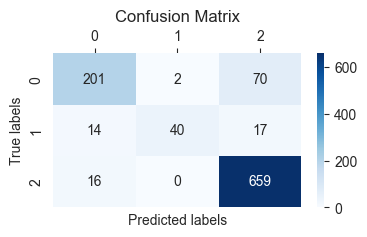


****** Label `cu_online` *******
TP:201	FP:30	FN:72	TN:716	 >> Precision:0.87	Recall:0.74	F1:0.8

****** Label `cu_others` *******
TP:40	FP:2	FN:31	TN:946	 >> Precision:0.95	Recall:0.56	F1:0.71

****** Label `cu_research` *******
TP:659	FP:87	FN:16	TN:257	 >> Precision:0.88	Recall:0.98	F1:0.93

OVERALL:
Accuracy 	==== 	88.322 %
Precision 	==== 	88.464 %
Recall Score	==== 	88.322 %
F1 SCORE 	==== 	87.742 %


In [210]:
plot_metrics(Y_test, Y_test_hat, sorted(Y.unique()))  # alphabetically arranged labels

In [221]:
# unseen tweet:

twt = "hello, is cub good at exploratory research studies?"

print("Predicted Class = ", model.predict(Vector.transform(pd.Series(twt))))

Predicted Class =  ['cu_research']


X -- X -